
# Sistema Multiagente para Reparto Urbano
Trabajo Final — Tópicos en Ciencias de la Computación

Este notebook implementa un **Sistema Multiagente (SMA)** donde varios **agentes repartidores**
cubren pedidos en una ciudad simplificada (grid 2D). Incluye:

1. **Simulación base de reparto multiagente.**
2. **Ventanas de tiempo en los pedidos** (time windows).
3. **Negociación / transferencia de pedidos entre agentes.**
4. **Visualización paso a paso** del movimiento de los agentes.

Se demuestran conceptos del curso:

- Sistemas Multiagente (SMA)
- Agentes IA con autonomía, reactividad, proactividad y sociabilidad
- Comunicación por mensajes (CFP, PROPOSE, ACCEPT, REJECT, REQUEST_TRANSFER, AGREE, REFUSE)
- Ventanas de tiempo y desempeño del sistema distribuido


In [ ]:
import random
from collections import deque, defaultdict
import matplotlib.pyplot as plt
import numpy as np

# Para reproducibilidad
random.seed(42)


## Modelo del Sistema Multiagente

### Entidades

- **Pedido**
  - `id`
  - `x`, `y`
  - `created_at`
  - `earliest_time` (inicio de ventana de tiempo)
  - `latest_time` (fin de ventana de tiempo)
  - `assigned` (bool)
  - `assigned_agent`
  - `delivered_at`

- **Mensaje**
  - `performative`: `"CFP"`, `"PROPOSE"`, `"ACCEPT"`, `"REJECT"`, `"REQUEST_TRANSFER"`, `"AGREE"`, `"REFUSE"`
  - `sender`
  - `receiver`
  - `content` (diccionario con información relevante)

- **AgenteRepartidor**
  - Estado: posición `(x, y)`, `capacity`, cola de pedidos `queue`
  - Estadísticas: `distance_travelled`, `completed_orders`, `log`
  - Comportamiento:
    - Responde a CFP con PROPOSE (si tiene capacidad y margen de tiempo).
    - Acepta pedidos asignados (ACCEPT).
    - Puede recibir transferencias de pedidos desde otros agentes.

- **Entorno**
  - Controla el tiempo discreto (`ticks`).
  - Genera pedidos dinámicamente con ventanas de tiempo.
  - Envía CFP a agentes.
  - Recibe propuestas y asigna pedidos.
  - Detecta **desequilibrios de carga** y genera intentos de negociación / transferencia.
  - Ejecuta el movimiento de los agentes.


In [ ]:
class Message:
    def __init__(self, performative, sender, receiver, content):
        self.performative = performative
        self.sender = sender
        self.receiver = receiver
        self.content = content

    def __repr__(self):
        return f"Message({self.performative}, from={self.sender}, to={self.receiver}, content={self.content})"


class Pedido:
    def __init__(self, pid, x, y, created_at, earliest_time, latest_time):
        self.id = pid
        self.x = x
        self.y = y
        self.created_at = created_at
        self.earliest_time = earliest_time
        self.latest_time = latest_time
        self.assigned = False
        self.assigned_agent = None
        self.delivered_at = None

    @property
    def expired(self):
        return self.latest_time is not None and self.delivered_at is None

    def __repr__(self):
        return (f"Pedido(id={self.id}, pos=({self.x},{self.y}), "
                f"[{self.earliest_time}-{self.latest_time}], "
                f"assigned={self.assigned}, agent={self.assigned_agent}, "
                f"delivered_at={self.delivered_at})")


In [ ]:
class AgenteRepartidor:
    def __init__(self, name, x=0, y=0, capacity=3):
        self.name = name
        self.x = x
        self.y = y
        self.capacity = capacity
        self.queue = deque()       # pedidos asignados y pendientes
        self.distance_travelled = 0
        self.messages_inbox = deque()
        self.completed_orders = []
        self.log = []

    def log_event(self, tick, event):
        self.log.append((tick, event))

    # Distancia Manhattan
    def distance_to_order(self, pedido):
        return abs(self.x - pedido.x) + abs(self.y - pedido.y)

    # Estimación grosera del tiempo hasta entregar un nuevo pedido
    def estimated_finish_time_for(self, pedido, current_tick):
        base = current_tick + self.distance_to_order(pedido)
        # sumamos 1 por cada pedido en cola como penalización aproximada
        return base + len(self.queue)

    # Evaluar si puede proponer tomar un pedido (considerando ventana de tiempo)
    def evaluate_order(self, pedido, current_tick):
        if len(self.queue) >= self.capacity:
            return None

        # Si aún no comenzó la ventana, se puede esperar
        eta = self.estimated_finish_time_for(pedido, current_tick)
        # Debe intentar llegar antes del latest_time
        if eta > pedido.latest_time:
            return None

        # Devolvemos una "puntuación": menor es mejor
        # Se prioriza cercanía y margen de tiempo
        urgency = max(0, pedido.latest_time - eta)
        score = self.distance_to_order(pedido) - 0.1 * urgency
        return score

    # Recibir mensaje
    def receive(self, message):
        self.messages_inbox.append(message)

    # Procesar mensajes
    def process_messages(self, tick):
        outgoing_messages = []

        while self.messages_inbox:
            msg = self.messages_inbox.popleft()

            if msg.performative == "CFP":
                pedido = msg.content["pedido"]
                score = self.evaluate_order(pedido, tick)
                if score is not None:
                    outgoing_messages.append(
                        Message(
                            performative="PROPOSE",
                            sender=self.name,
                            receiver=msg.sender,
                            content={"pedido_id": pedido.id, "score": score}
                        )
                    )
                else:
                    self.log_event(tick, f"Rechaza CFP por pedido {pedido.id} (capacidad o ventana)")

            elif msg.performative == "ACCEPT":
                pedido = msg.content["pedido"]
                self.assign_order(pedido)
                self.log_event(tick, f"Pedido {pedido.id} asignado por entorno")

            elif msg.performative == "REJECT":
                pedido_id = msg.content["pedido_id"]
                self.log_event(tick, f"Propuesta rechazada para pedido {pedido_id}")

            elif msg.performative == "REQUEST_TRANSFER":
                # Otro agente quiere transferirnos un pedido
                pedido = msg.content["pedido"]
                score = self.evaluate_order(pedido, tick)
                if score is not None:
                    # Acepta la transferencia
                    self.assign_order(pedido)
                    outgoing_messages.append(
                        Message(
                            performative="AGREE",
                            sender=self.name,
                            receiver=msg.sender,
                            content={"pedido_id": pedido.id}
                        )
                    )
                    self.log_event(tick, f"Acepta transferencia del pedido {pedido.id}")
                else:
                    outgoing_messages.append(
                        Message(
                            performative="REFUSE",
                            sender=self.name,
                            receiver=msg.sender,
                            content={"pedido_id": pedido.id}
                        )
                    )
                    self.log_event(tick, f"Rechaza transferencia del pedido {pedido.id}")

            elif msg.performative == "AGREE":
                # El otro agente aceptó la transferencia: aquí solo se loggea
                pedido_id = msg.content["pedido_id"]
                self.log_event(tick, f"Transferencia del pedido {pedido_id} aceptada por receptor")

            elif msg.performative == "REFUSE":
                pedido_id = msg.content["pedido_id"]
                self.log_event(tick, f"Transferencia del pedido {pedido_id} rechazada por receptor")

        return outgoing_messages

    def assign_order(self, pedido):
        self.queue.append(pedido)
        pedido.assigned = True
        pedido.assigned_agent = self.name

    def step_movement(self, tick):
        if not self.queue:
            return None

        current = self.queue[0]
        prev_x, prev_y = self.x, self.y

        if self.x < current.x:
            self.x += 1
        elif self.x > current.x:
            self.x -= 1
        elif self.y < current.y:
            self.y += 1
        elif self.y > current.y:
            self.y -= 1
        else:
            # Entregado
            self.queue.popleft()
            self.completed_orders.append(current)
            current.delivered_at = tick
            self.log_event(tick, f"Entregado pedido {current.id} en ({current.x},{current.y})")
            return current

        self.distance_travelled += abs(self.x - prev_x) + abs(self.y - prev_y)
        return None

    def __repr__(self):
        return (f"<Agente {self.name} pos=({self.x},{self.y}) "
                f"queue={len(self.queue)} completed={len(self.completed_orders)}>")


In [ ]:
class Entorno:
    def __init__(self, width=20, height=20, max_orders=20, order_spawn_prob=0.3):
        self.width = width
        self.height = height
        self.agents = []
        self.orders = []
        self.current_tick = 0
        self.next_order_id = 0
        self.max_orders = max_orders
        self.order_spawn_prob = order_spawn_prob
        self.assignment_log = []
        self.transfer_log = []

    def add_agent(self, agent):
        self.agents.append(agent)

    def spawn_order(self):
        if len(self.orders) >= self.max_orders:
            return None
        x = random.randint(0, self.width - 1)
        y = random.randint(0, self.height - 1)

        created_at = self.current_tick
        earliest_time = created_at  # puede ser ejecutable apenas aparece
        slack = random.randint(8, 18)
        latest_time = created_at + slack

        pedido = Pedido(
            pid=self.next_order_id,
            x=x,
            y=y,
            created_at=created_at,
            earliest_time=earliest_time,
            latest_time=latest_time
        )
        self.next_order_id += 1
        self.orders.append(pedido)
        return pedido

    def send_message(self, message):
        for agent in self.agents:
            if agent.name == message.receiver:
                agent.receive(message)
                break

    def broadcast_cfp(self, pedido):
        for agent in self.agents:
            agent.receive(Message(
                performative="CFP",
                sender="ENV",
                receiver=agent.name,
                content={"pedido": pedido}
            ))

    def try_rebalance_load(self, tick):
        # Estrategia sencilla: si un agente tiene cola >= 2 más grande que otro,
        # intenta transferir el pedido más "tarde" (id más grande) al agente menos cargado.
        if len(self.agents) < 2:
            return []

        outgoing_messages = []

        queues = [(ag, len(ag.queue)) for ag in self.agents]
        queues_sorted = sorted(queues, key=lambda x: x[1])
        least_loaded = queues_sorted[0][0]
        most_loaded = queues_sorted[-1][0]

        if queues_sorted[-1][1] - queues_sorted[0][1] >= 2 and most_loaded.queue:
            # candidato a transferir: el último de la cola
            pedido = list(most_loaded.queue)[-1]
            # solo tiene sentido si aún no ha expirado
            if tick < pedido.latest_time:
                msg = Message(
                    performative="REQUEST_TRANSFER",
                    sender=most_loaded.name,
                    receiver=least_loaded.name,
                    content={"pedido": pedido}
                )
                # El mensaje va al receptor, y se espera respuesta en el próximo proceso
                least_loaded.receive(msg)
                self.transfer_log.append((tick, pedido.id, most_loaded.name, least_loaded.name))
                most_loaded.log_event(tick, f"Intenta transferir pedido {pedido.id} a {least_loaded.name}")
                outgoing_messages.append(msg)

        return outgoing_messages

    def step(self):
        tick = self.current_tick

        # 1. Generar nuevos pedidos
        if random.random() < self.order_spawn_prob:
            pedido = self.spawn_order()
            if pedido:
                self.broadcast_cfp(pedido)

        # 2. Agentes procesan mensajes y generan salidas (propuestas o respuestas)
        proposals_by_order = defaultdict(list)
        agent_messages_to_send = []

        for agent in self.agents:
            outgoing = agent.process_messages(tick)
            for msg in outgoing:
                if msg.performative == "PROPOSE":
                    pedido_id = msg.content["pedido_id"]
                    proposals_by_order[pedido_id].append(msg)
                else:
                    # Mensajes entre agentes (AGREE/REFUSE) o al entorno
                    agent_messages_to_send.append(msg)

        # Enviar mensajes resultantes (AGREE/REFUSE) entre agentes
        for msg in agent_messages_to_send:
            self.send_message(msg)

        # 3. Entorno decide asignación de pedidos según propuestas
        for pedido_id, proposals in proposals_by_order.items():
            pedido = next((p for p in self.orders if p.id == pedido_id), None)
            if pedido is None or pedido.assigned:
                continue

            best_prop = min(proposals, key=lambda m: m.content["score"])
            winner = best_prop.sender

            for prop in proposals:
                if prop.sender == winner:
                    self.send_message(Message(
                        performative="ACCEPT",
                        sender="ENV",
                        receiver=winner,
                        content={"pedido": pedido}
                    ))
                else:
                    self.send_message(Message(
                        performative="REJECT",
                        sender="ENV",
                        receiver=prop.sender,
                        content={"pedido_id": pedido_id}
                    ))

            self.assignment_log.append((tick, pedido_id, winner))

        # 4. Intento de rebalanceo de carga (negociación / transferencia)
        self.try_rebalance_load(tick)

        # 5. Movimiento de agentes
        delivered_this_tick = []
        for agent in self.agents:
            delivered = agent.step_movement(tick)
            if delivered:
                delivered_this_tick.append(delivered)

        self.current_tick += 1
        return delivered_this_tick

    def run(self, max_ticks=250):
        all_delivered = []

        for _ in range(max_ticks):
            delivered = self.step()
            all_delivered.extend(delivered)

            if len(self.orders) >= self.max_orders:
                # condición de parada si todos los pedidos generados están entregados
                if all(p.delivered_at is not None or self.current_tick > p.latest_time for p in self.orders):
                    break

        return all_delivered



## Ejecución de la simulación principal


In [ ]:
env = Entorno(width=20, height=20, max_orders=20, order_spawn_prob=0.4)

agents = [
    AgenteRepartidor("A1", x=0, y=0, capacity=4),
    AgenteRepartidor("A2", x=19, y=0, capacity=4),
    AgenteRepartidor("A3", x=10, y=19, capacity=4),
]

for ag in agents:
    env.add_agent(ag)

delivered_orders = env.run(max_ticks=250)

print(f"Ticks ejecutados: {env.current_tick}")
print(f"Pedidos generados: {len(env.orders)}")
print(f"Pedidos entregados: {len([p for p in env.orders if p.delivered_at is not None])}")
print(f"Pedidos vencidos (no entregados antes de latest_time): {len([p for p in env.orders if p.delivered_at is None and env.current_tick > p.latest_time])}")

for ag in agents:
    print(ag)


Ticks ejecutados: 42
Pedidos generados: 20
Pedidos entregados: 7
Pedidos vencidos (no entregados antes de latest_time): 13
<Agente A1 pos=(1,10) queue=3 completed=2>
<Agente A2 pos=(18,11) queue=3 completed=2>
<Agente A3 pos=(1,14) queue=2 completed=3>



## Visualización del estado final


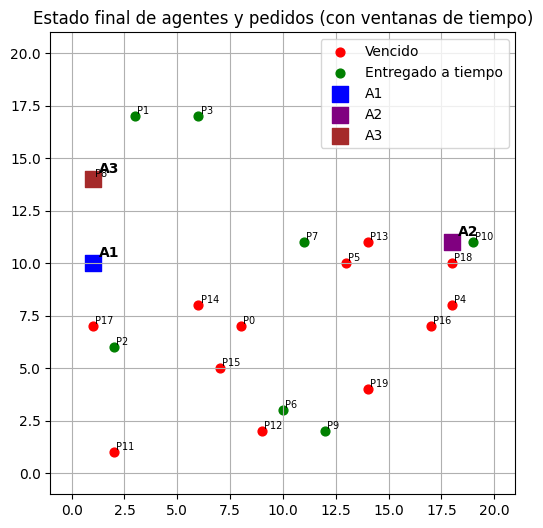

In [ ]:
plt.figure(figsize=(6, 6))

# Pedidos
for p in env.orders:
    if p.delivered_at is not None:
        color = "green"
        label = "Entregado a tiempo" if "Entregado a tiempo" not in plt.gca().get_legend_handles_labels()[1] else ""
    elif env.current_tick > p.latest_time:
        color = "red"
        label = "Vencido" if "Vencido" not in plt.gca().get_legend_handles_labels()[1] else ""
    else:
        color = "orange"
        label = "Aún activo" if "Aún activo" not in plt.gca().get_legend_handles_labels()[1] else ""

    plt.scatter(p.x, p.y, color=color, s=40, label=label)
    plt.text(p.x + 0.1, p.y + 0.1, f"P{p.id}", fontsize=7)

# Agentes
colors = ["blue", "purple", "brown"]
for idx, ag in enumerate(env.agents):
    plt.scatter(ag.x, ag.y, color=colors[idx], s=120, marker="s", label=ag.name if ag.name not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.text(ag.x + 0.3, ag.y + 0.3, ag.name, fontsize=10, fontweight="bold")

plt.title("Estado final de agentes y pedidos (con ventanas de tiempo)")
plt.xlim(-1, env.width + 1)
plt.ylim(-1, env.height + 1)
plt.grid(True)
plt.legend()
plt.show()



## Métricas de desempeño


Pedidos entregados por agente:
  A1: 2 pedidos
  A2: 2 pedidos
  A3: 3 pedidos

Distancia recorrida por agente:
  A1: 35 unidades
  A2: 26 unidades
  A3: 36 unidades

Equidad (desviación estándar de pedidos entregados):
  STD = 0.4714045207910317

Pedidos entregados a tiempo: 4
Pedidos vencidos (no entregados): 13


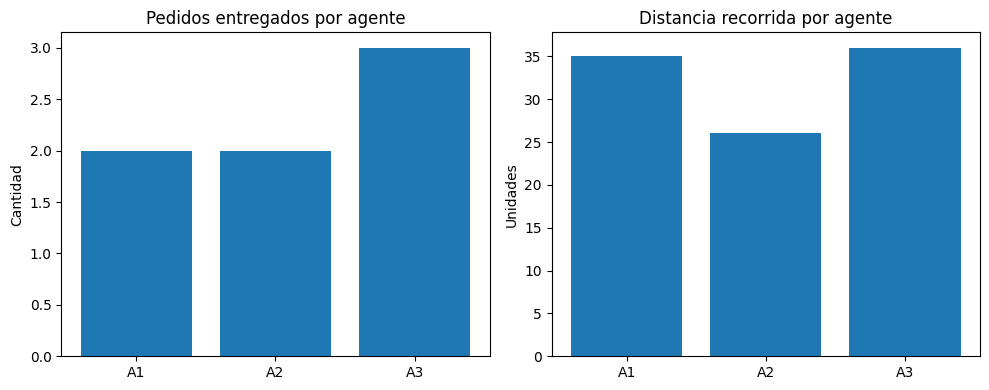

In [ ]:

workloads = [len(ag.completed_orders) for ag in env.agents]
distances = [ag.distance_travelled for ag in env.agents]
names = [ag.name for ag in env.agents]

print("Pedidos entregados por agente:")
for ag, w in zip(env.agents, workloads):
    print(f"  {ag.name}: {w} pedidos")

print("\nDistancia recorrida por agente:")
for ag, d in zip(env.agents, distances):
    print(f"  {ag.name}: {d} unidades")

if workloads:
    print("\nEquidad (desviación estándar de pedidos entregados):")
    print("  STD =", np.std(workloads))

on_time = [p for p in env.orders if p.delivered_at is not None and p.delivered_at <= p.latest_time]
late_or_missed = [p for p in env.orders if p.delivered_at is None and env.current_tick > p.latest_time]

print(f"\nPedidos entregados a tiempo: {len(on_time)}")
print(f"Pedidos vencidos (no entregados): {len(late_or_missed)}")

# Gráficos de barras
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(names, workloads)
axes[0].set_title("Pedidos entregados por agente")
axes[0].set_ylabel("Cantidad")

axes[1].bar(names, distances)
axes[1].set_title("Distancia recorrida por agente")
axes[1].set_ylabel("Unidades")

plt.tight_layout()
plt.show()



## Log de eventos de un agente (trazabilidad)


In [ ]:
agent_to_inspect = env.agents[0]
print(f"Log de eventos del agente {agent_to_inspect.name} (máx. 25 líneas):\n")
for i, (tick, event) in enumerate(agent_to_inspect.log[:25]):
    print(f"[tick {tick}] {event}")

Log de eventos del agente A1 (máx. 25 líneas):

[tick 1] Rechaza CFP por pedido 0 (capacidad o ventana)
[tick 2] Rechaza CFP por pedido 1 (capacidad o ventana)
[tick 5] Pedido 2 asignado por entorno
[tick 6] Rechaza CFP por pedido 3 (capacidad o ventana)
[tick 7] Rechaza CFP por pedido 4 (capacidad o ventana)
[tick 9] Rechaza CFP por pedido 5 (capacidad o ventana)
[tick 11] Pedido 6 asignado por entorno
[tick 11] Rechaza CFP por pedido 7 (capacidad o ventana)
[tick 13] Propuesta rechazada para pedido 8
[tick 13] Entregado pedido 2 en (2,6)
[tick 14] Propuesta rechazada para pedido 9
[tick 14] Rechaza CFP por pedido 10 (capacidad o ventana)
[tick 15] Acepta transferencia del pedido 8
[tick 16] Pedido 11 asignado por entorno
[tick 16] Rechaza CFP por pedido 12 (capacidad o ventana)
[tick 18] Rechaza CFP por pedido 13 (capacidad o ventana)
[tick 20] Pedido 14 asignado por entorno
[tick 20] Intenta transferir pedido 14 a A2
[tick 21] Intenta transferir pedido 14 a A3
[tick 22] Transferenci


## Visualización paso a paso (animación simple)

A continuación se ejecuta una **simulación corta** y se dibuja el mapa en cada tick,
mostrando el movimiento de los agentes y la aparición/estado de los pedidos.


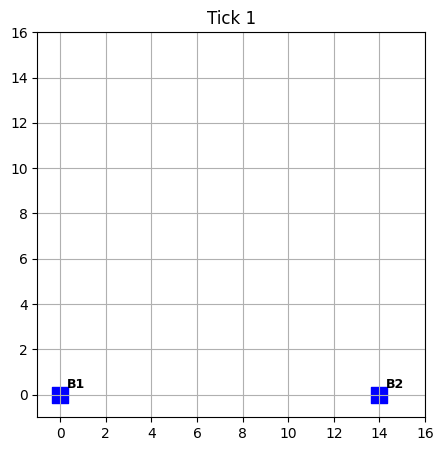

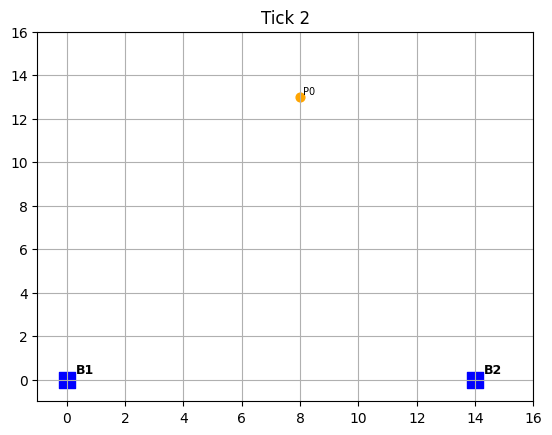

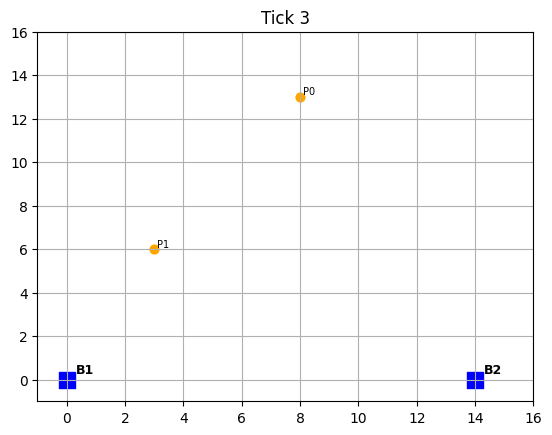

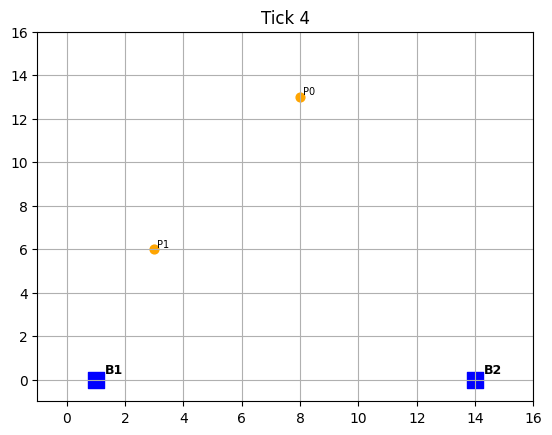

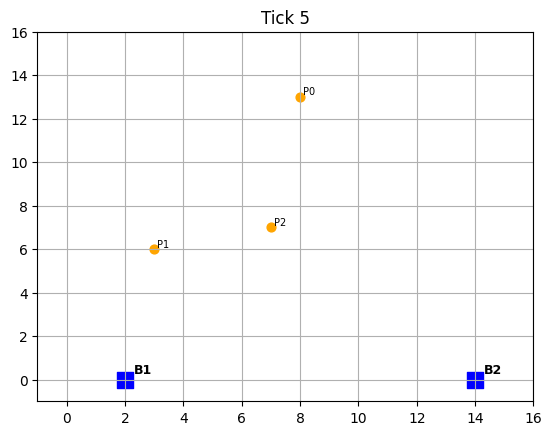

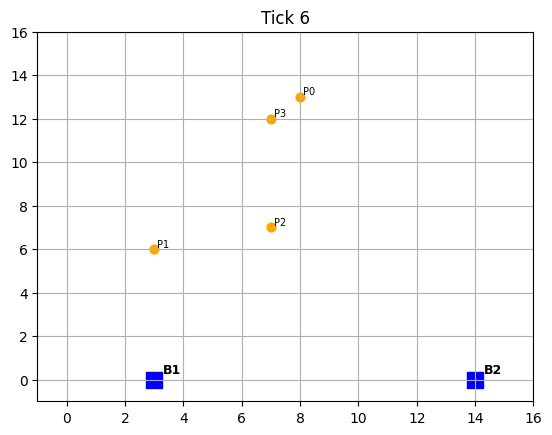

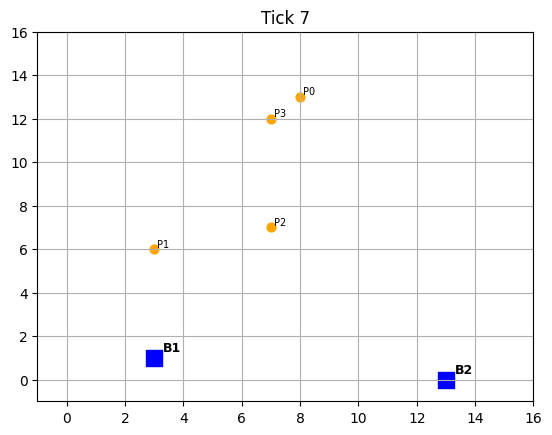

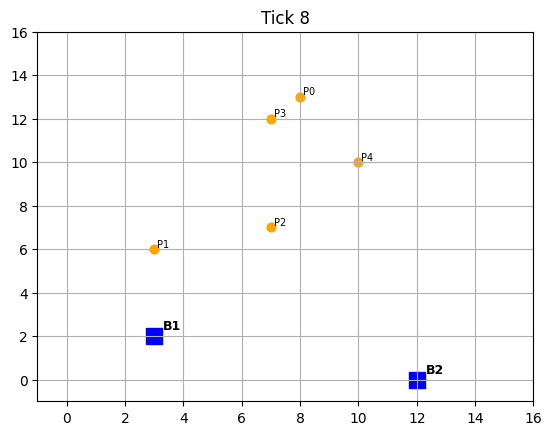

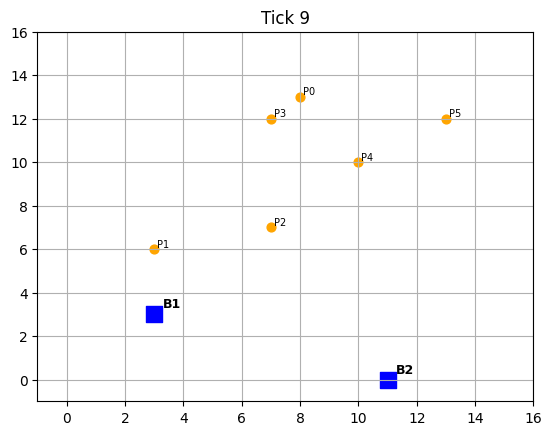

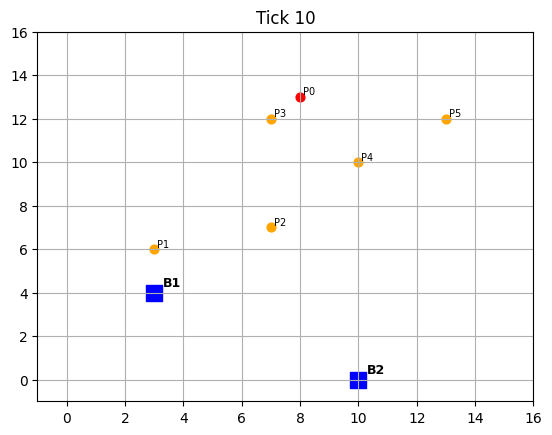

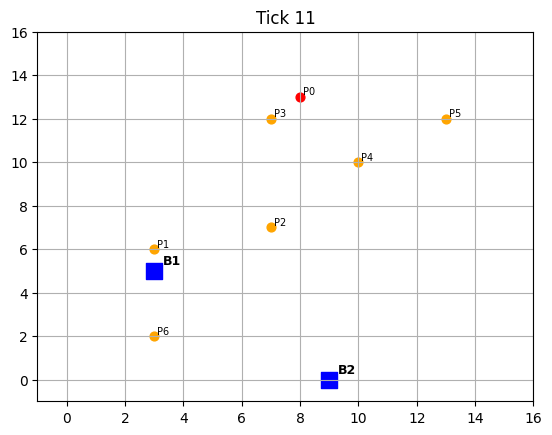

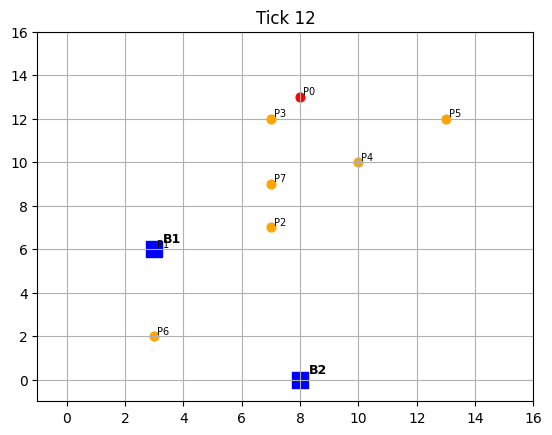

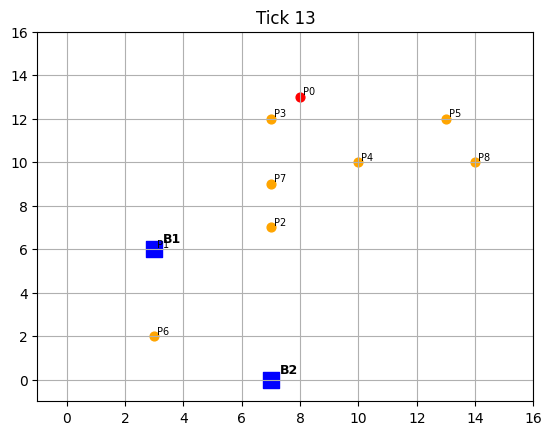

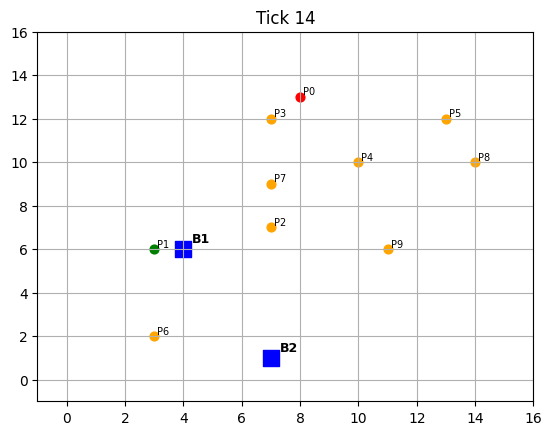

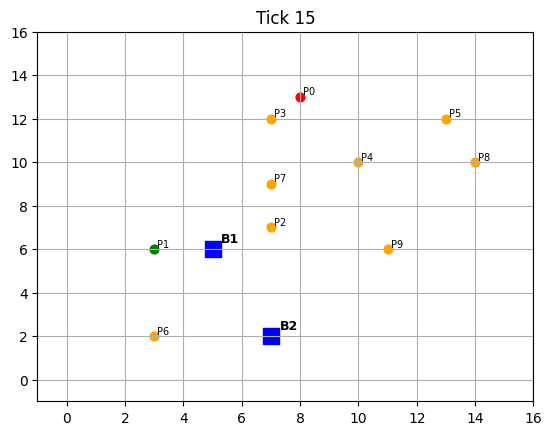

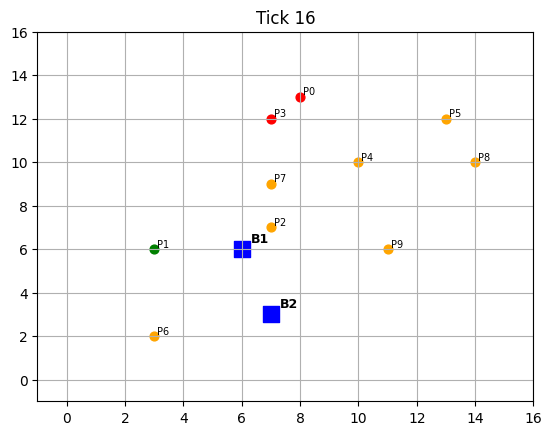

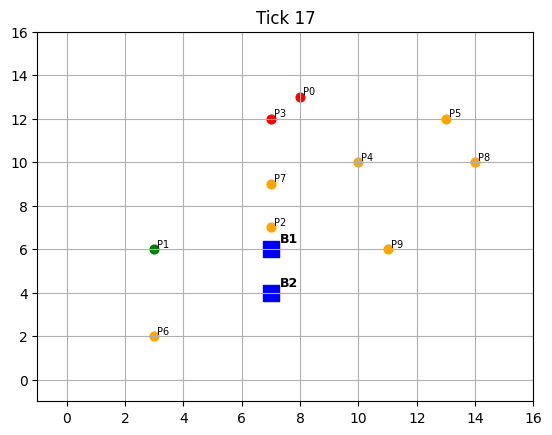

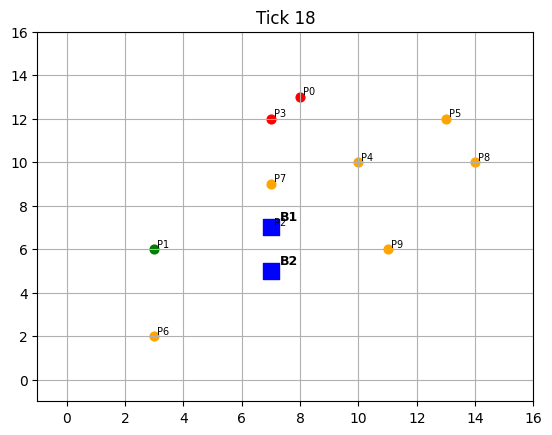

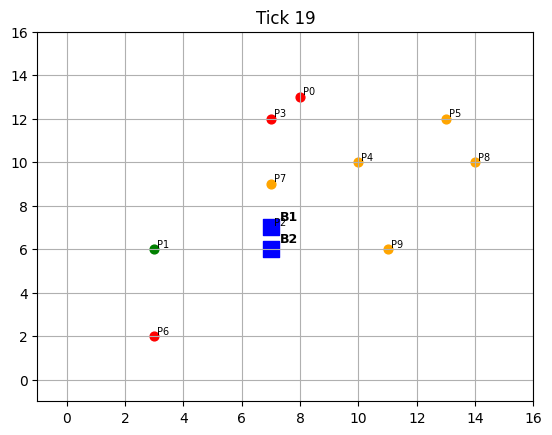

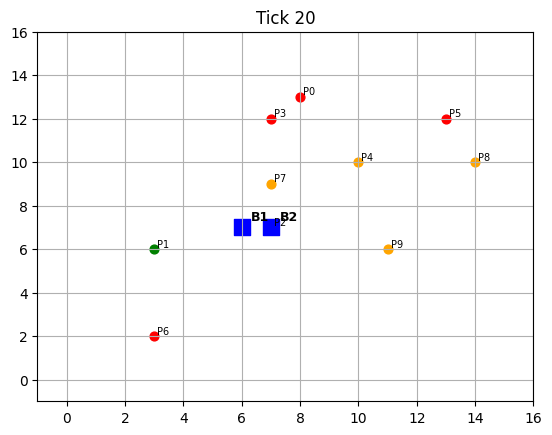

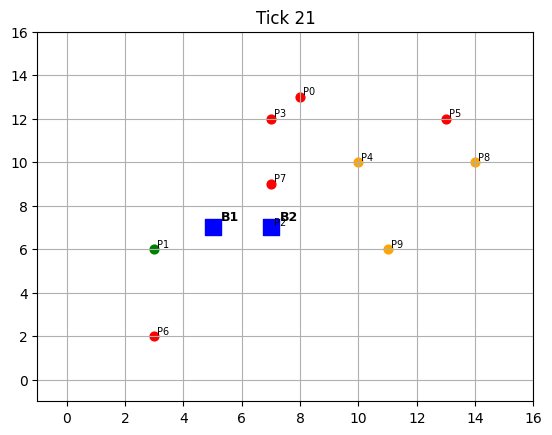

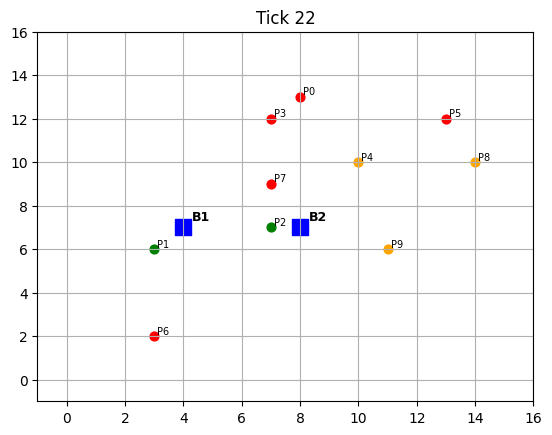

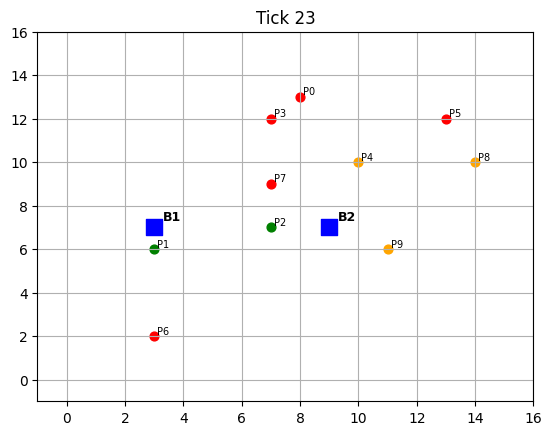

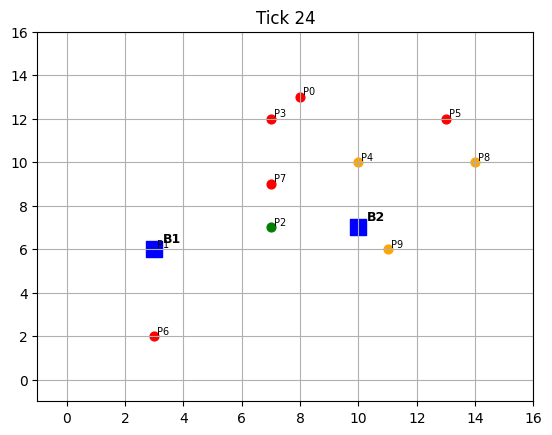

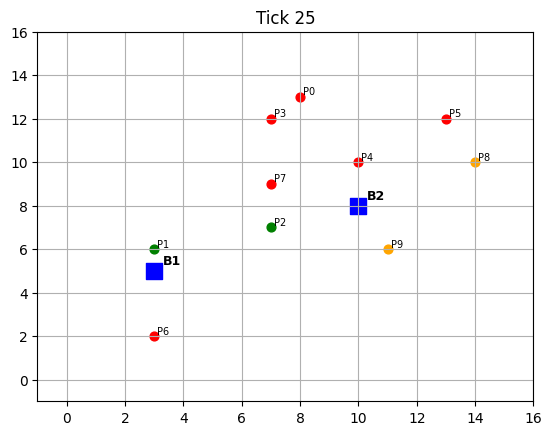

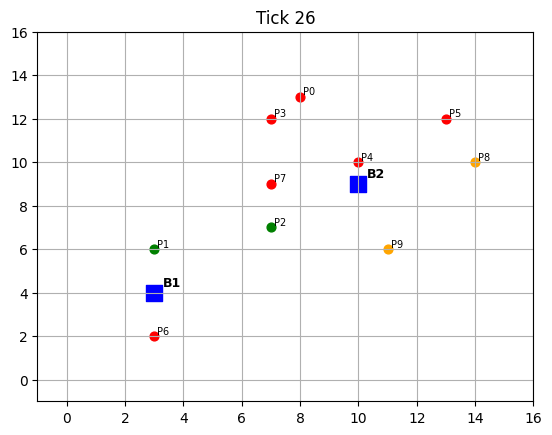

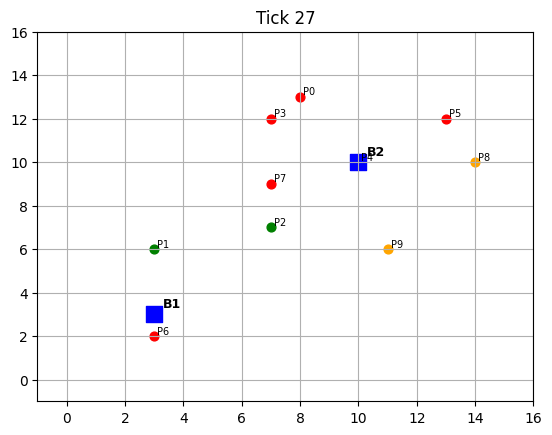

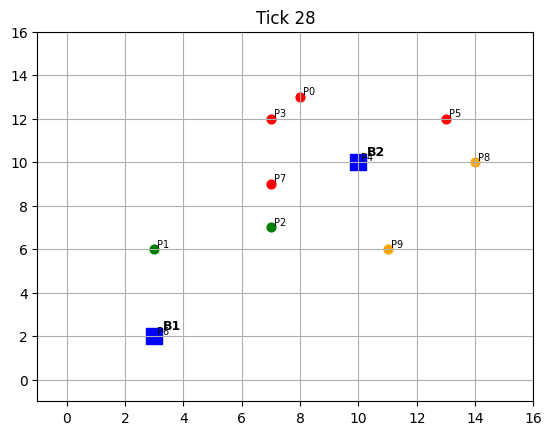

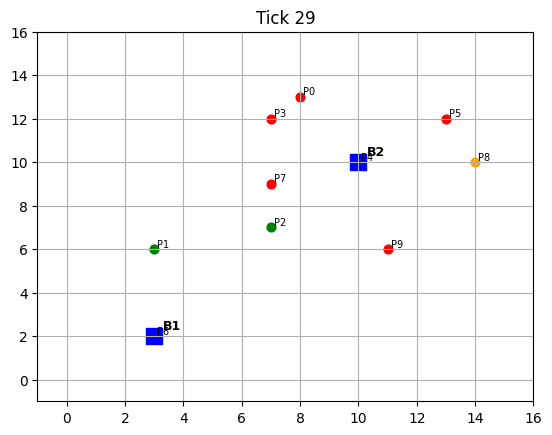

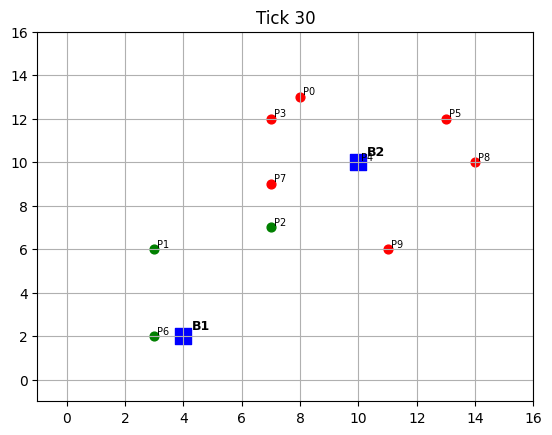

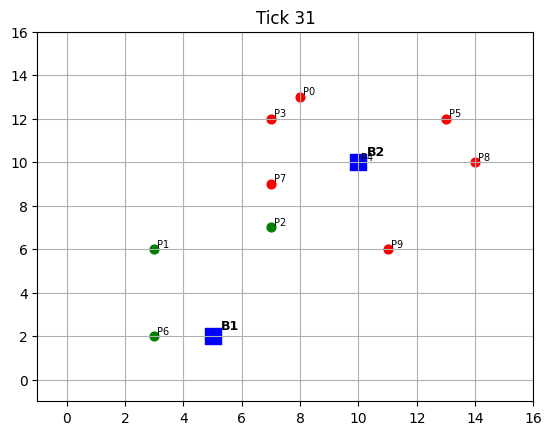

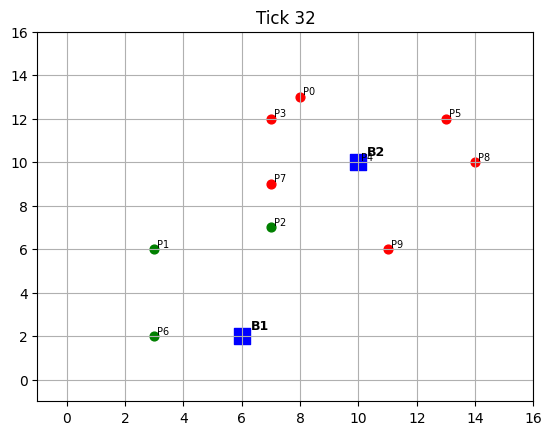

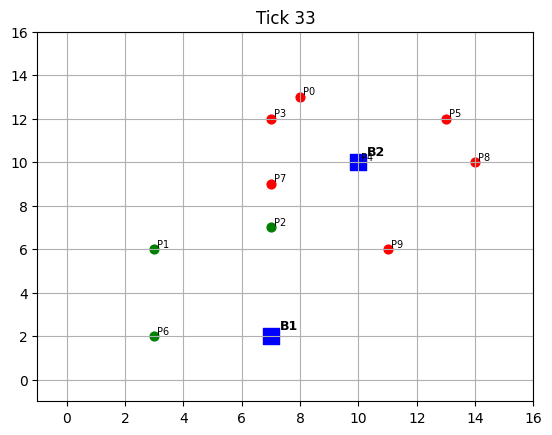

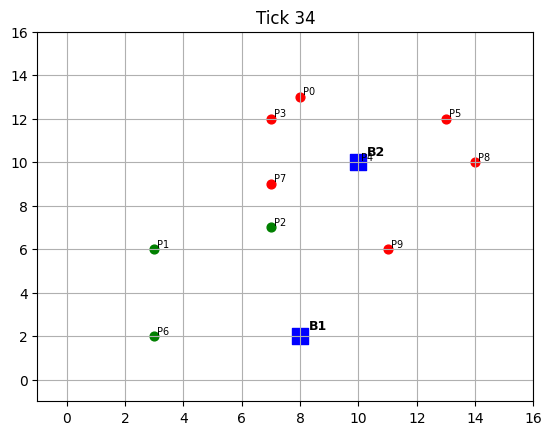

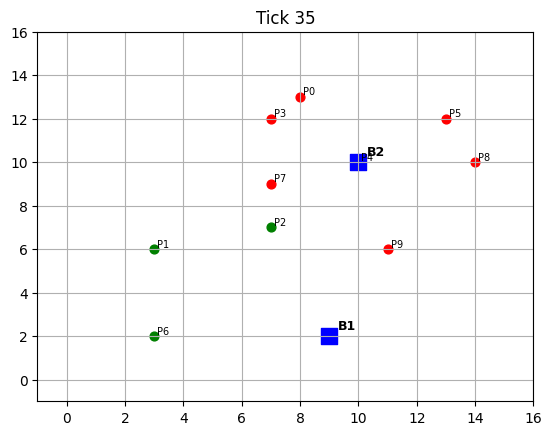

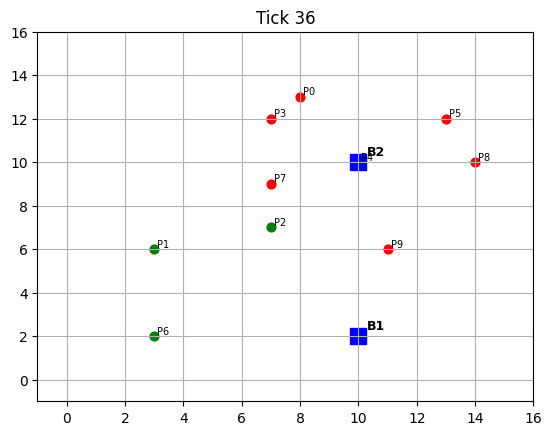

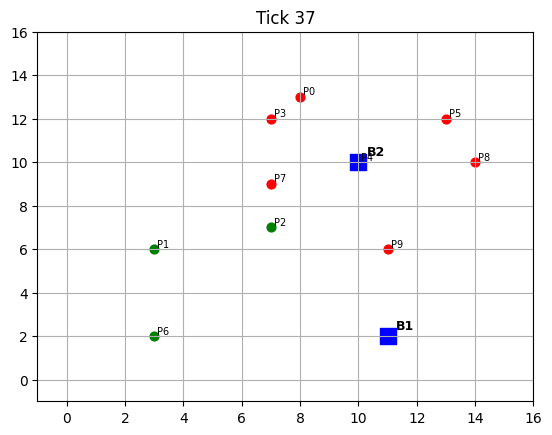

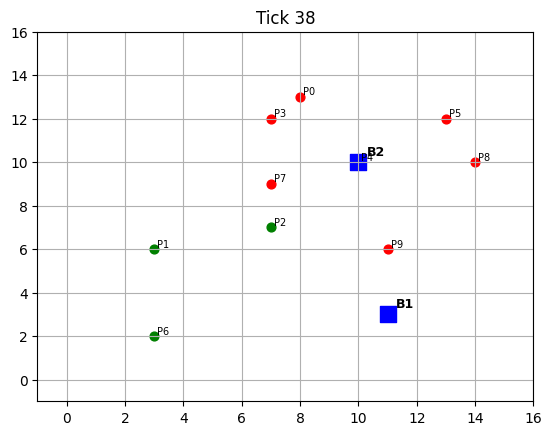

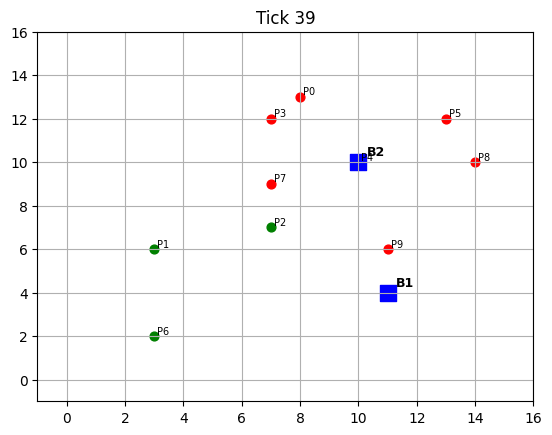

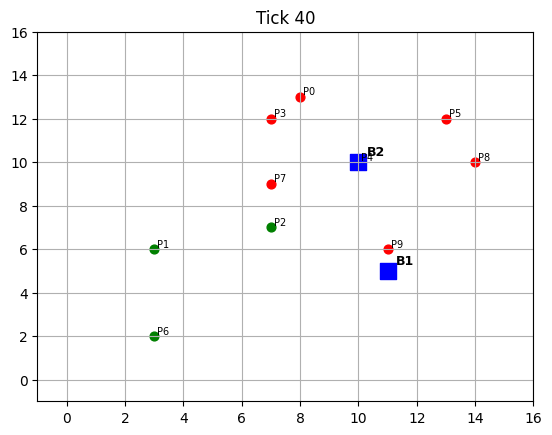

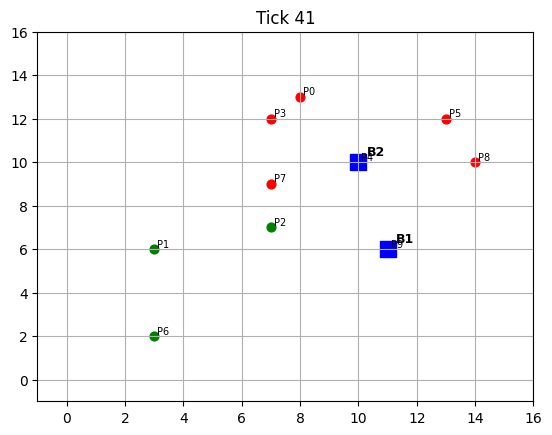

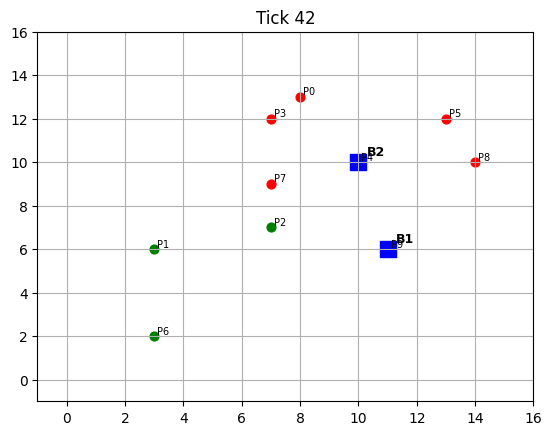

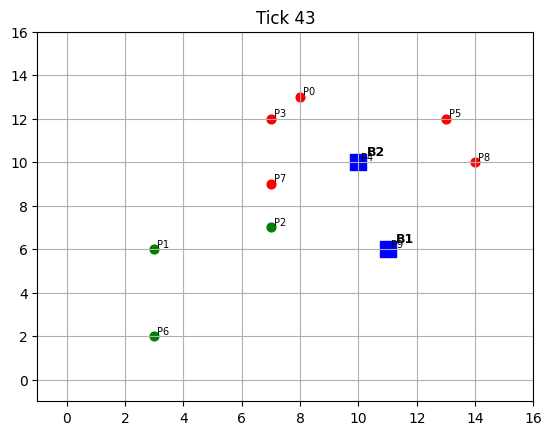

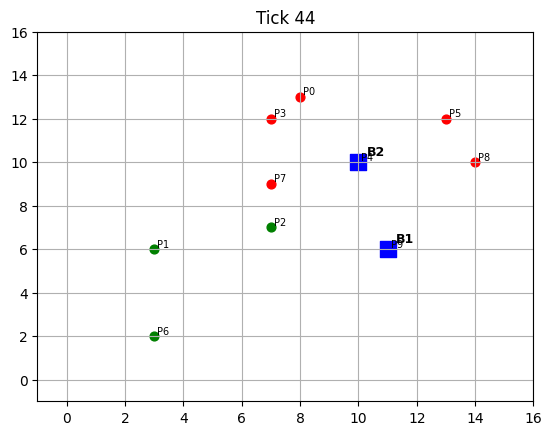

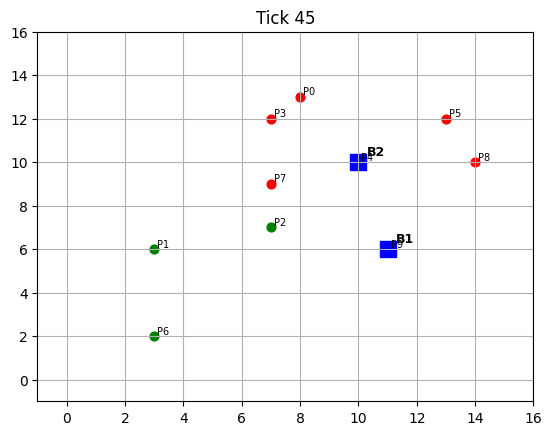

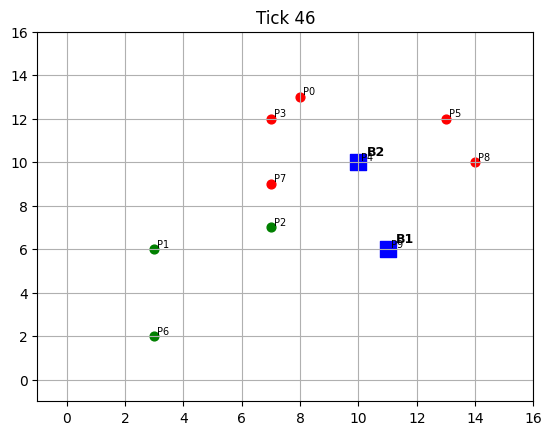

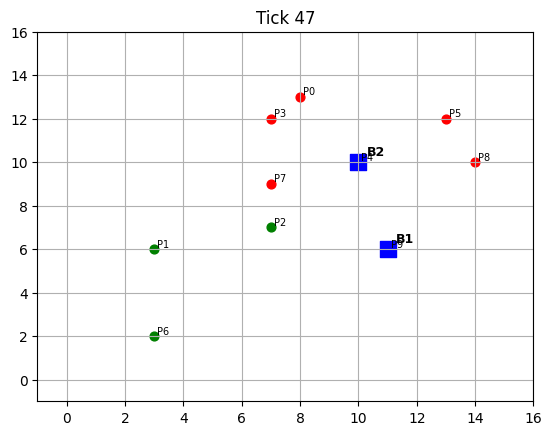

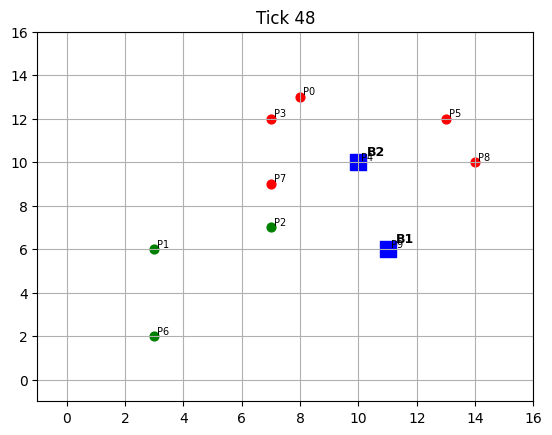

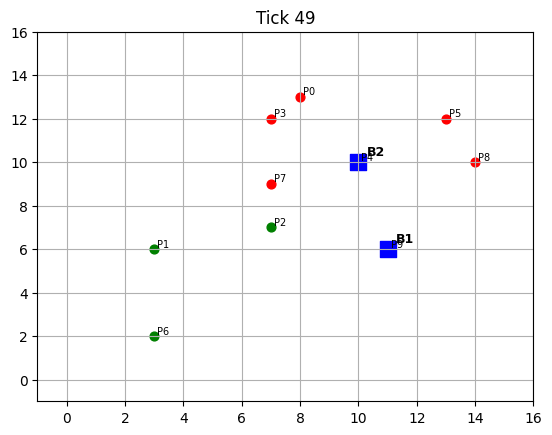

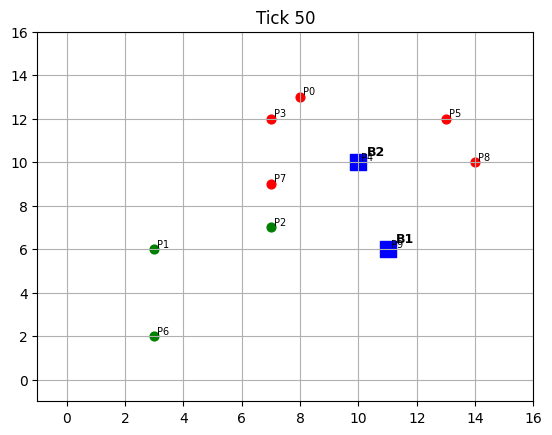

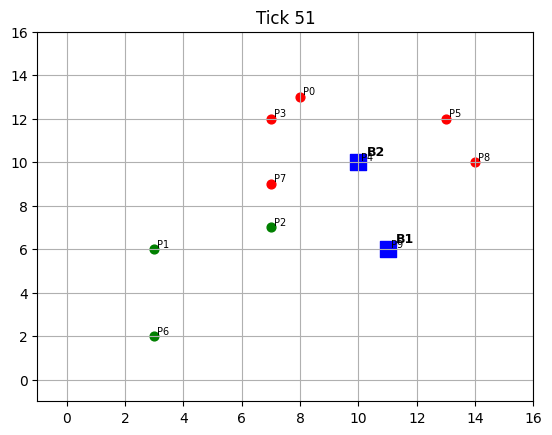

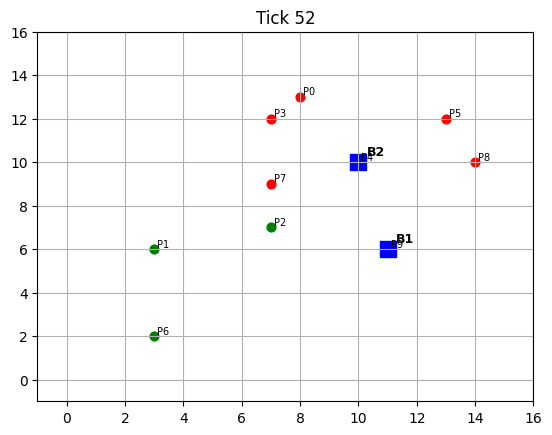

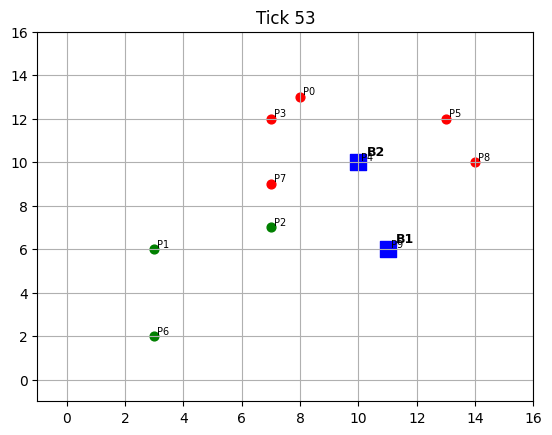

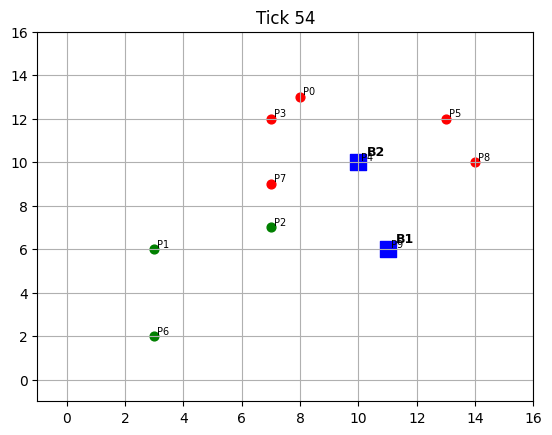

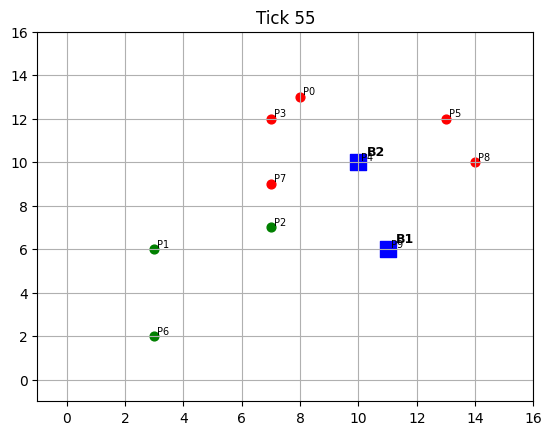

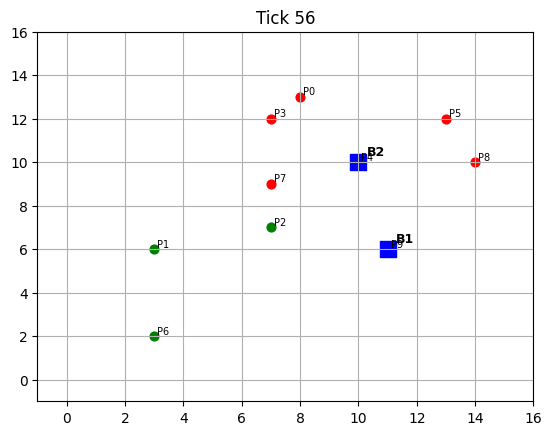

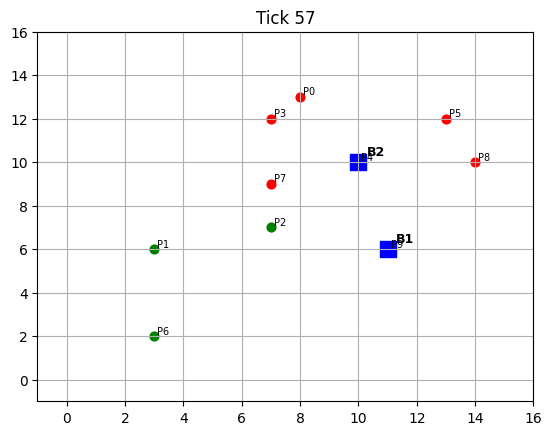

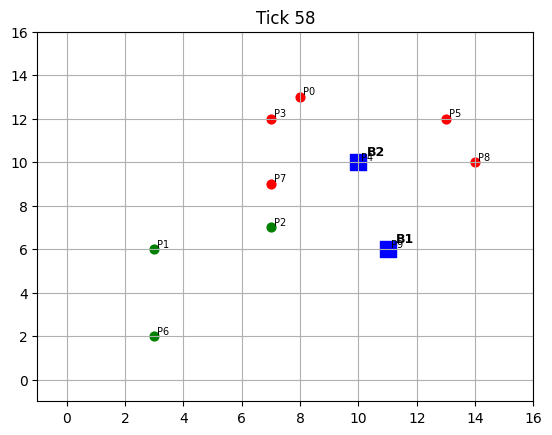

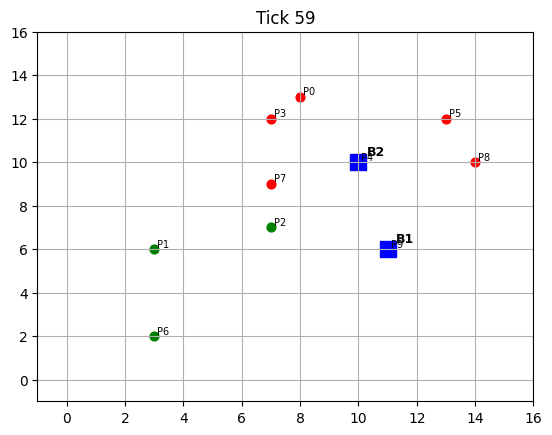

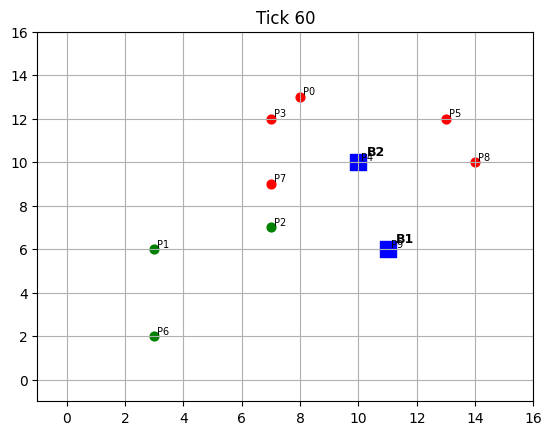

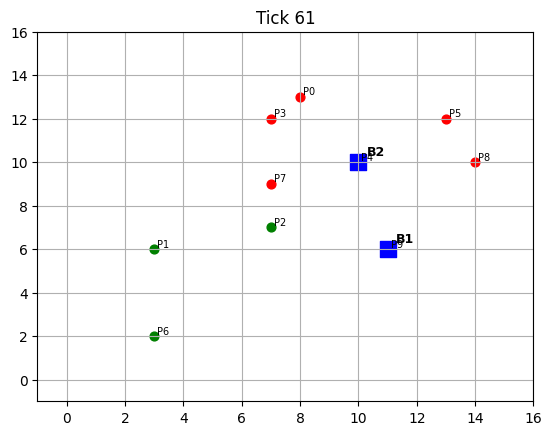

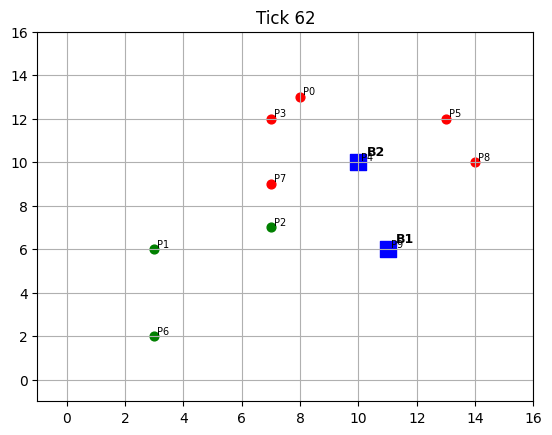

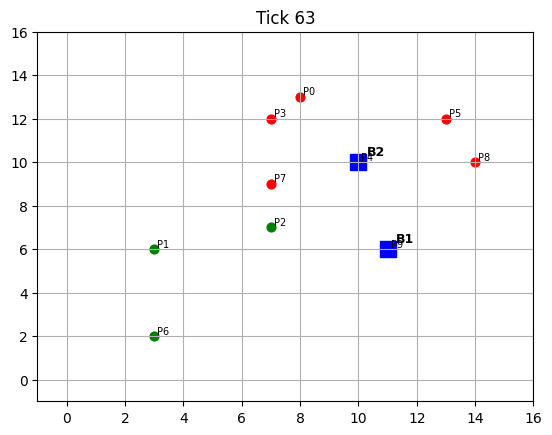

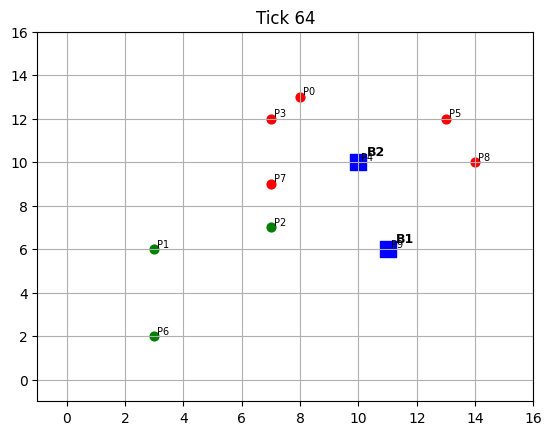

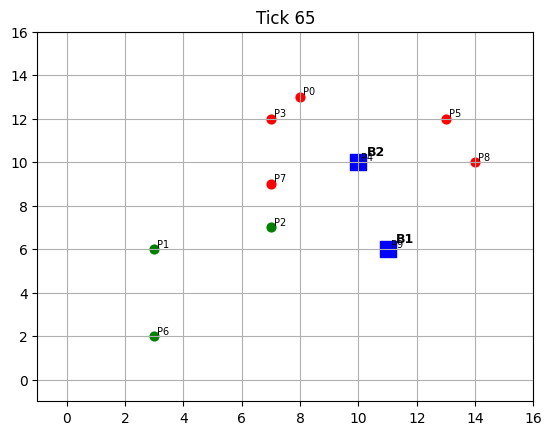

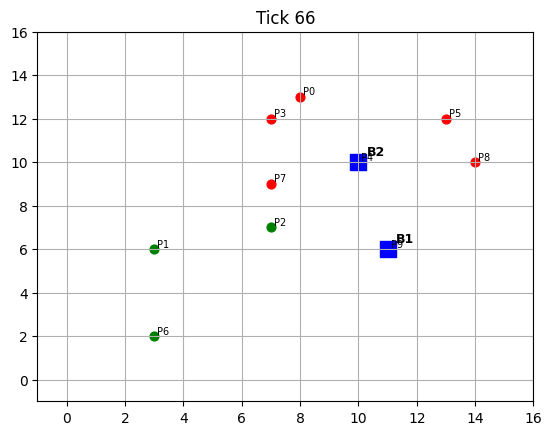

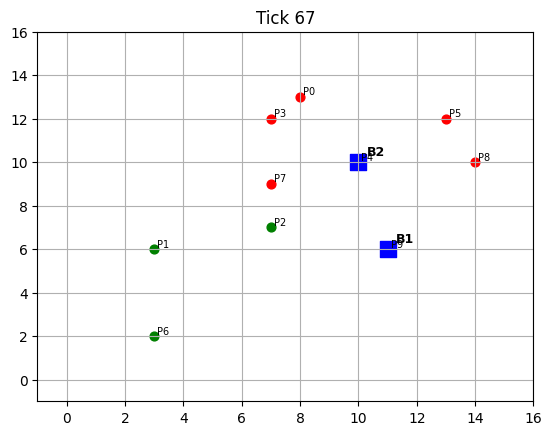

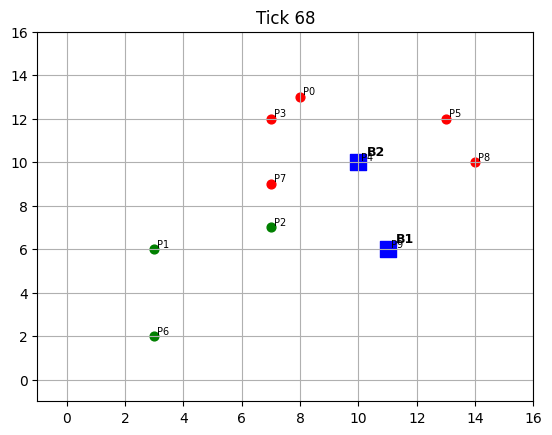

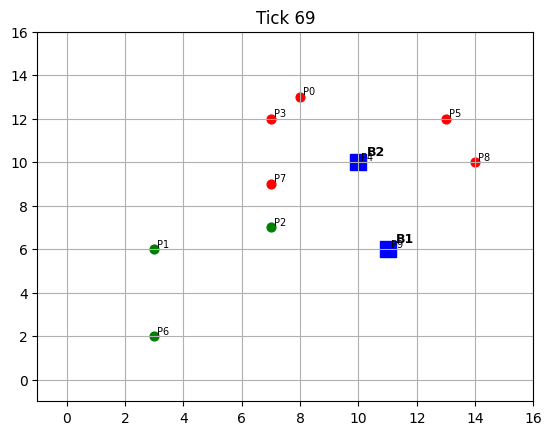

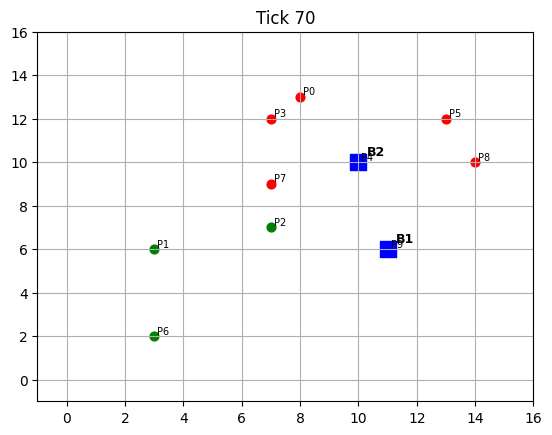

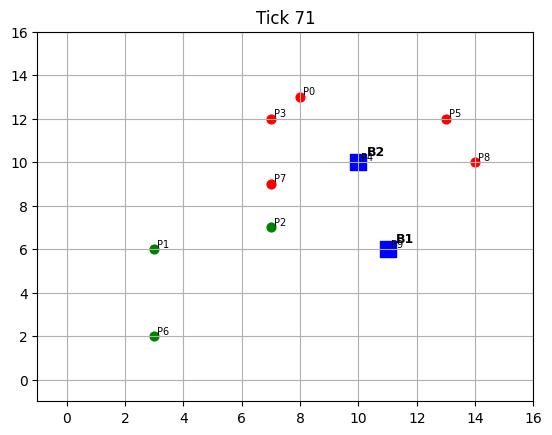

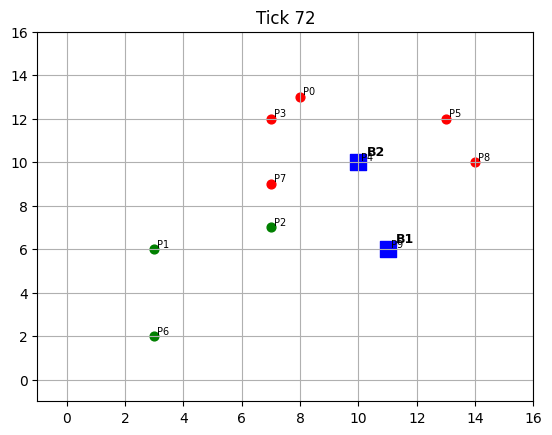

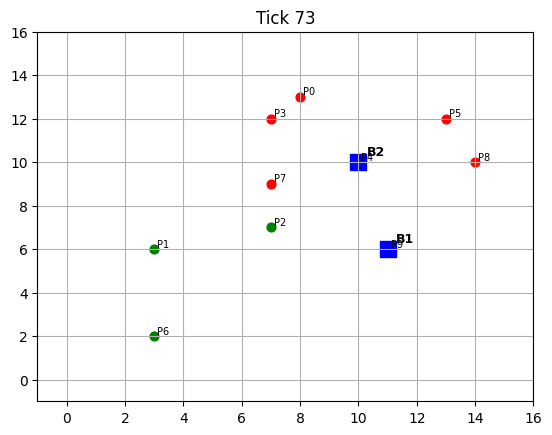

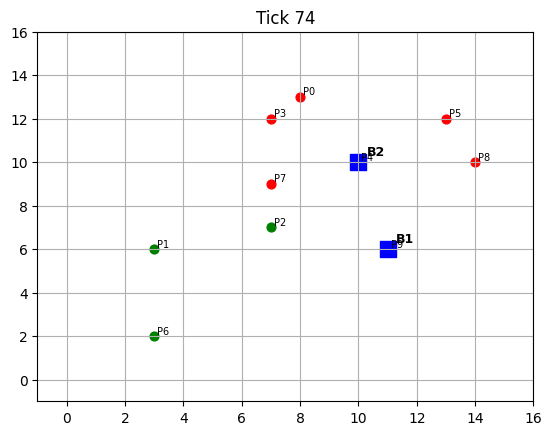

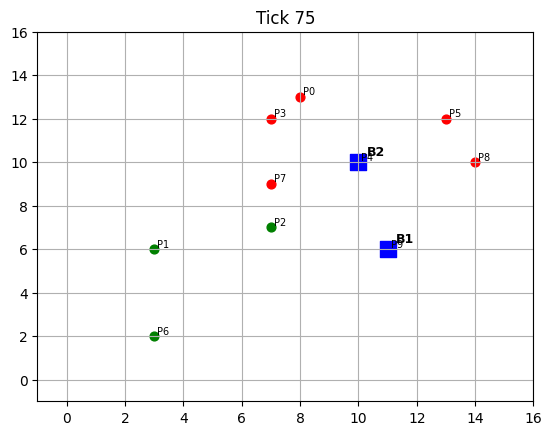

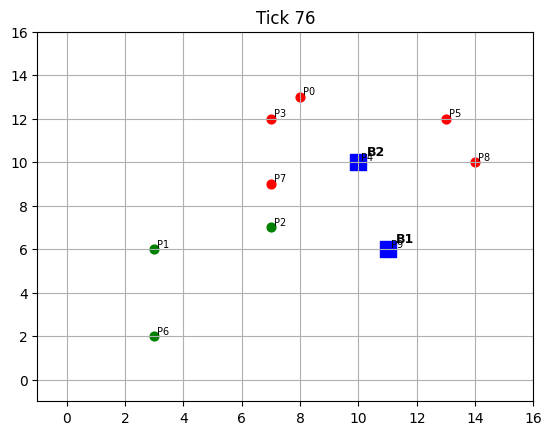

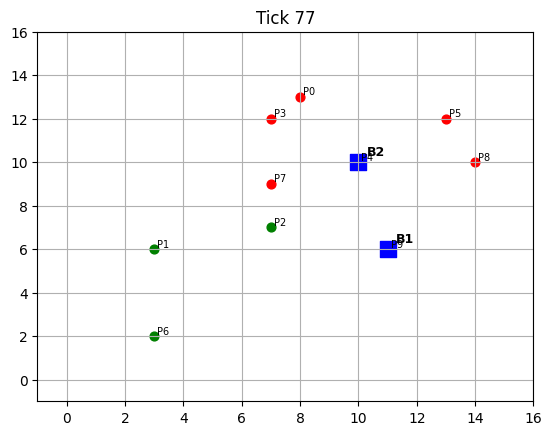

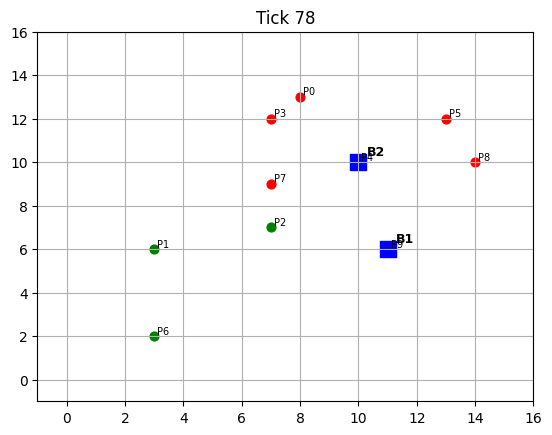

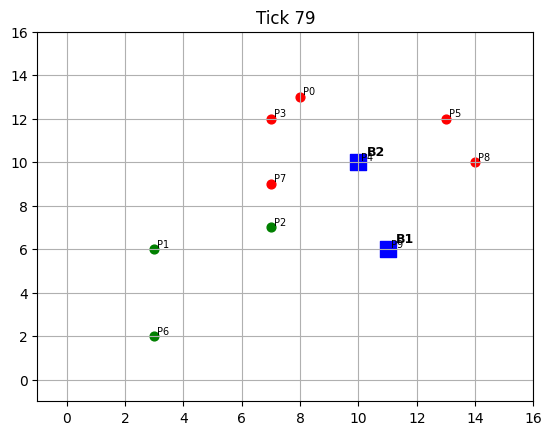

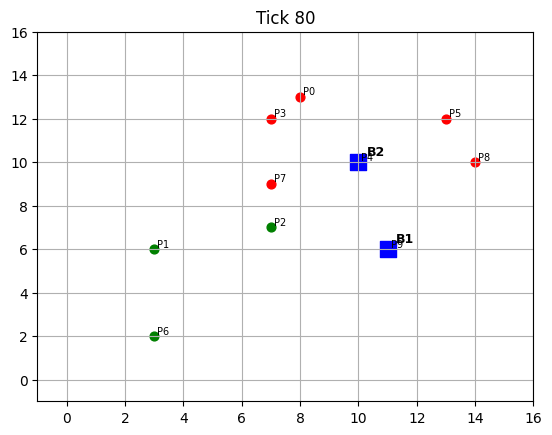

In [ ]:
# Simulación corta para animación
env_anim = Entorno(width=15, height=15, max_orders=10, order_spawn_prob=0.5)
agents_anim = [
    AgenteRepartidor("B1", x=0, y=0, capacity=3),
    AgenteRepartidor("B2", x=14, y=0, capacity=3),
]

for ag in agents_anim:
    env_anim.add_agent(ag)

plt.figure(figsize=(5, 5))

for _ in range(80):
    env_anim.step()

    plt.clf()

    # Dibujar pedidos
    for p in env_anim.orders:
        if p.delivered_at is not None:
            color = "green"
        elif env_anim.current_tick > p.latest_time:
            color = "red"
        else:
            color = "orange"
        plt.scatter(p.x, p.y, color=color, s=40)
        plt.text(p.x + 0.1, p.y + 0.1, f"P{p.id}", fontsize=7)

    # Dibujar agentes
    for ag in env_anim.agents:
        plt.scatter(ag.x, ag.y, color="blue", s=120, marker="s")
        plt.text(ag.x + 0.3, ag.y + 0.3, ag.name, fontsize=9, fontweight="bold")

    plt.title(f"Tick {env_anim.current_tick}")
    plt.xlim(-1, env_anim.width + 1)
    plt.ylim(-1, env_anim.height + 1)
    plt.grid(True)
    plt.pause(0.1)

plt.show()



## Conclusiones

- Se ha implementado un **Sistema Multiagente de reparto urbano** con:
  - Asignación distribuida de pedidos mediante CFP/PROPOSE/ACCEPT/REJECT.
  - **Ventanas de tiempo** en los pedidos, que afectan las decisiones de los agentes.
  - Un mecanismo sencillo de **negociación/transferencia de pedidos** entre agentes para rebalancear carga.
  - Visualización del estado final y una animación paso a paso del movimiento de los agentes.

- Cada agente exhibe:
  - **Autonomía** al decidir qué pedidos aceptar según su capacidad y tiempo.
  - **Reactividad** frente a nuevos pedidos (CFP) y mensajes de transferencia.
  - **Proactividad** al intentar entregar sus pedidos y cooperar con otros agentes.
  - **Sociabilidad** mediante intercambio de mensajes (propuestas, aceptaciones y rechazos).

- Las métricas y gráficos permiten analizar:
  - La distribución de la carga de trabajo entre agentes.
  - El costo en distancia recorrida.
  - El cumplimiento de las ventanas de tiempo (pedidos a tiempo vs. vencidos).

Este prototipo puede extenderse fácilmente para:
- Modelar diferentes tipos de agentes (velocidades, capacidades, zonas preferidas).
- Incorporar funciones de utilidad más complejas al evaluar pedidos.
- Integrar técnicas de optimización en la capa central de asignación.
